In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from  sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import pickle
import json

def plot_bhk_scatter_plot(df,location):
    df_2bhk = df[(df['location']==location)&(df['size']==2)]
    df_3bhk = df[(df['location']==location)&(df['size']==3)]
    plt.figure(figsize=(15, 10))
    plt.scatter(df_2bhk['total_sqft'],df_2bhk['price_pre_sqrft'],color='red',s=50)
    plt.scatter(df_3bhk['total_sqft'],df_3bhk['price_pre_sqrft'],color='blue',s=50,marker='*')
    plt.xlabel('Total sqft')
    plt.ylabel('Price per sqft')
    plt.title('Locations')
    plt.legend(['2 BHK' , '3 BHK'])

**Creating a data frame using bengaluru_house_prices.csv file.**


In [13]:
df = pd.read_csv('Balaji_ project_PricePrediction\\src\\price prediction.ipynb')



FileNotFoundError: [Errno 2] No such file or directory: 'Balaji_ project_PricePrediction\\src\\price prediction.ipynb'

**Removing all the columns that are not gonna make any impact on the price of the house.**

In [6]:
df = df.drop(['area_type','availability','balcony','society'],axis='columns')
df.head()

NameError: name 'df' is not defined

**This shows the number of NA or null values present in the dataset in each column.**

In [ ]:
df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

**Droping all the NaN values present in the dataset.**

In [ ]:
df = df.dropna()
df['total_sqft'][30]


'2100 - 2850'

In [ ]:
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

**Fuction to clear the total_sqft column.**


cleaning the sqft cloumn and calcualting price_pre_sqrft .

In [ ]:
#Fuction to clear the total_sqft column.
def conver_total_sqft(x):
    temp = x.split('-')
    if len(temp) == 2:
        return ((float(temp[0])) + (float(temp[1]))) / 2
    try :
        return float(x)
    except:
        return None 
#cleaning the sqft cloumn.  
df['total_sqft'] = df['total_sqft'].apply(conver_total_sqft)
#Calcualting price_pre_sqrft .
df['price_pre_sqrft'] = df['price']*100000/df['total_sqft']
df['size']=df['size'].apply(lambda x: int(x.split(' ')[0]))

**Unique loactions in the dataset.**

In [ ]:
len(df['location'].unique())

1304

In [ ]:
df['location']= df['location'].apply(lambda x: x.strip())
df_loctemp = df.groupby('location')['location'].agg('count')
df_loctemp

location
1 Annasandrapalya                                  1
1 Giri Nagar                                       1
1 Immadihalli                                      1
1 Ramamurthy Nagar                                 1
12th cross srinivas nagar banshankari 3rd stage    1
                                                  ..
t.c palya                                          1
tc.palya                                           4
vinayakanagar                                      1
white field,kadugodi                               1
whitefiled                                         1
Name: location, Length: 1293, dtype: int64

**Replacing all the locations with 'other' if the location have less than 10 datapoint .**

In [ ]:
df_loctemp = df_loctemp[df_loctemp<=10]
df['location'] = df['location'].apply(lambda x: 'other' if x in df_loctemp else x)

In [ ]:
len(df['location'].unique())
df.head()

,location,size,total_sqft,bath,price,price_pre_sqrft
0,Electronic City Phase II,2,1056.0,2.0,39.07,3699.810606
1,Chikka Tirupathi,4,2600.0,5.0,120.00,4615.384615
2,Uttarahalli,3,1440.0,2.0,62.00,4305.555556
3,Lingadheeranahalli,3,1521.0,3.0,95.00,6245.890861
4,Kothanur,2,1200.0,2.0,51.00,4250.000000


**Removing all the outliers. In this case we consider a data is a outlier by considering that the minimun value of total_srft/size is 300.**

In [ ]:

df = df[~(df['total_sqft']/df['size']<300)]
df.shape

(12502, 6)

**Removing extreme cases where the price_pre_sqrft is very low or very high.**

In [ ]:
def remove_outliers(df):
    df_res = pd.DataFrame()
    for key,subf in df.groupby('location'):
        mean_res = np.mean(subf.price_pre_sqrft)
        standard_div_res = np.std(subf.price_pre_sqrft)
        res_df = subf[(subf.price_pre_sqrft>(mean_res-standard_div_res)) & (subf.price_pre_sqrft<=(mean_res+standard_div_res))]
        df_res = pd.concat([df_res,res_df],ignore_index=True)
    return df_res

df1 = remove_outliers(df)

In [ ]:
df1.shape

(10241, 6)

In [ ]:
df1

,location,size,total_sqft,bath,price,price_pre_sqrft
0,1st Block Jayanagar,4,2850.0,4.0,428.00,15017.543860
1,1st Block Jayanagar,3,1630.0,3.0,194.00,11901.840491
2,1st Block Jayanagar,3,1875.0,2.0,235.00,12533.333333
3,1st Block Jayanagar,3,1200.0,2.0,130.00,10833.333333
4,1st Block Jayanagar,2,1235.0,2.0,148.00,11983.805668
...,...,...,...,...,...,...
10236,other,2,1353.0,2.0,110.00,8130.081301
10237,other,1,812.0,1.0,26.00,3201.970443
10238,other,3,1440.0,2.0,63.93,4439.583333
10239,other,2,1075.0,2.0,48.00,4465.116279


**We can see from the scatter plot that some 3bhk properties have low price per square than 2bhk properties so we need to remove these anomalies.**

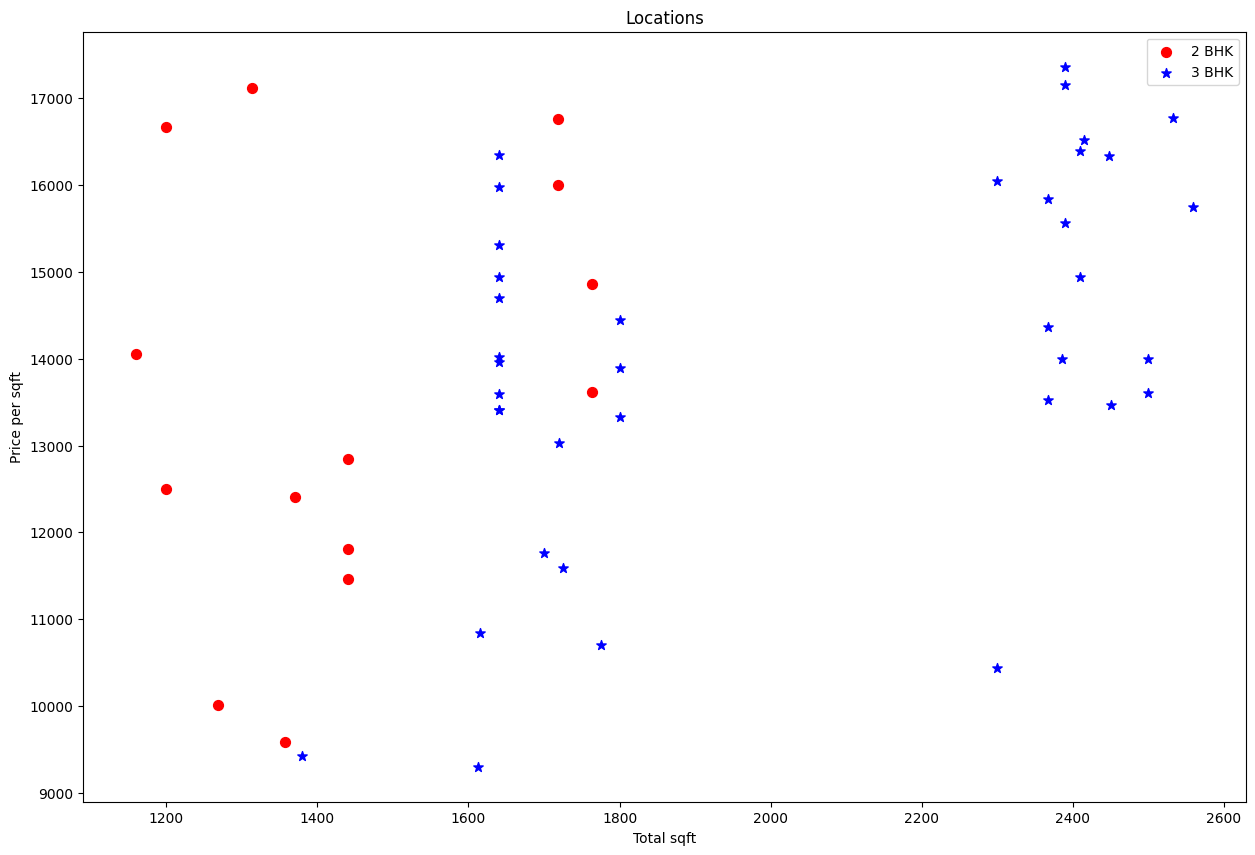

In [ ]:
plot_bhk_scatter_plot(df1,'Rajaji Nagar')

**Function to remove all the outliers.**

In [ ]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('size'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df['price_pre_sqrft']),
                'std': np.std(bhk_df['price_pre_sqrft']),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('size'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df['price_pre_sqrft']<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df2 = remove_bhk_outliers(df1)
df2

,location,size,total_sqft,bath,price,price_pre_sqrft
0,1st Block Jayanagar,4,2850.0,4.0,428.0,15017.543860
1,1st Block Jayanagar,3,1630.0,3.0,194.0,11901.840491
2,1st Block Jayanagar,3,1875.0,2.0,235.0,12533.333333
3,1st Block Jayanagar,3,1200.0,2.0,130.0,10833.333333
4,1st Block Jayanagar,2,1235.0,2.0,148.0,11983.805668
...,...,...,...,...,...,...
10232,other,2,1200.0,2.0,70.0,5833.333333
10233,other,1,1800.0,1.0,200.0,11111.111111
10236,other,2,1353.0,2.0,110.0,8130.081301
10237,other,1,812.0,1.0,26.0,3201.970443


**All the 3 bhk properties have higher price per sqft than 2 bhk properties.**

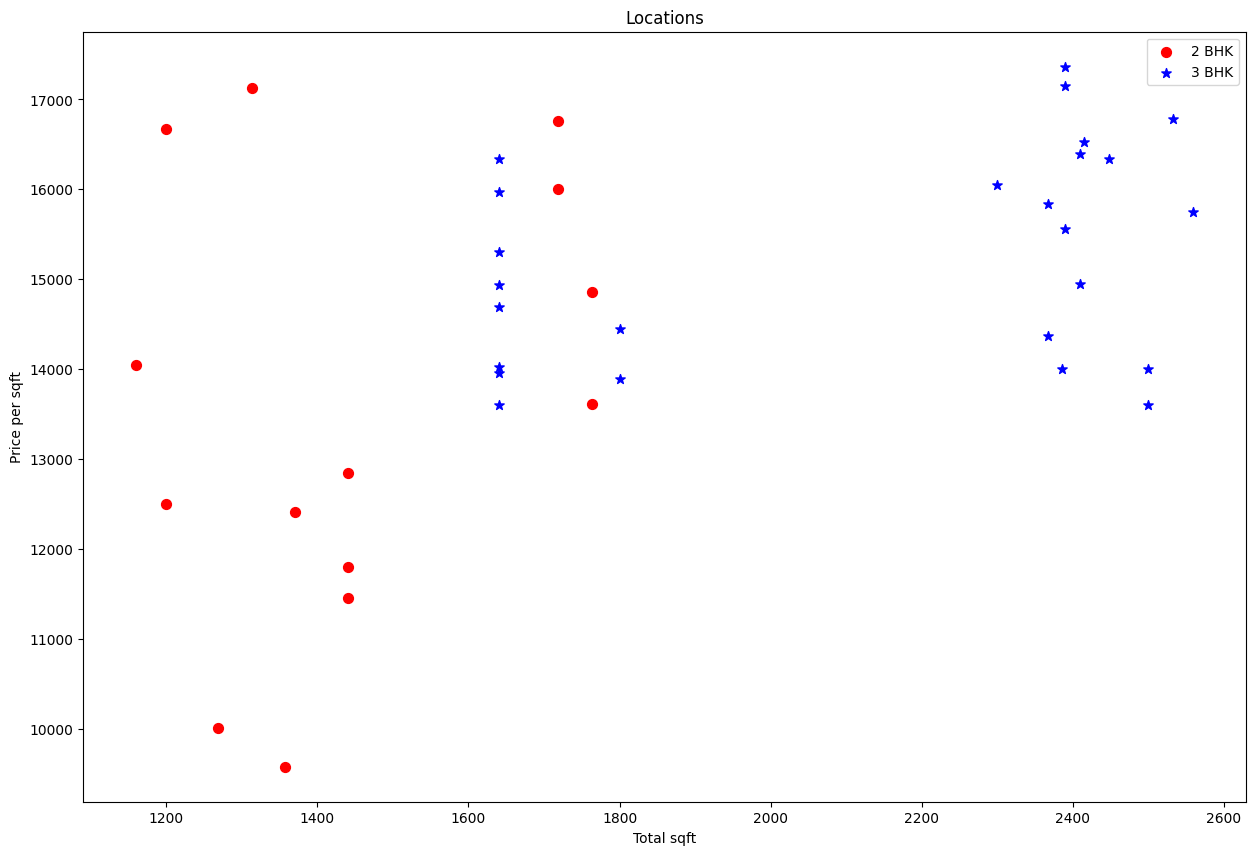

In [ ]:
plot_bhk_scatter_plot(df2,'Rajaji Nagar')

**Removing datapoints if the have bathroom more than its bhk +2**

In [ ]:
df2 = df2[df2['bath']<df2['size']+2]

**One hot encoding for location coloumn**

In [ ]:
dummies = pd.get_dummies(df2['location'])
dummies= dummies.drop('other',axis='columns')
dummies

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10232,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10233,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10236,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10237,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Concate the dummies and main dataframe**

In [ ]:
df2 = pd.concat([df2,dummies],axis='columns')
df2 = df2.drop('location',axis='columns')
df2

,size,total_sqft,bath,price,price_pre_sqrft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,4,2850.0,4.0,428.0,15017.543860,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3,1630.0,3.0,194.0,11901.840491,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,1875.0,2.0,235.0,12533.333333,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,1200.0,2.0,130.0,10833.333333,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2,1235.0,2.0,148.0,11983.805668,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10232,2,1200.0,2.0,70.0,5833.333333,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10233,1,1800.0,1.0,200.0,11111.111111,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10236,2,1353.0,2.0,110.0,8130.081301,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10237,1,812.0,1.0,26.0,3201.970443,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Creating X and y variables for traning and using train_test_split on it.**

In [ ]:

X = df2.drop(['price','price_pre_sqrft'],axis='columns')
y= df2['price']
X_train , X_test ,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=40)


**Creating a LinearRegression model**

In [ ]:
model = LinearRegression()
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.8790086358878415

**K-crossvalidation**

In [ ]:
cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=40)
cross_val_score(LinearRegression(),X,y,cv=cv)

array([0.87900864, 0.80308349, 0.88772622, 0.8687454 , 0.88276292])

**Funtion to predict price of a property**

In [ ]:
def predict_price(size ,total_sqft, bath, location):
    location_indx = np.where(X.columns==location)[0][0]
    
    predict_x = np.zeros(len(X.columns))
    predict_x[0] = size
    predict_x[1] = total_sqft
    predict_x[2] = bath
    if location_indx >= 0:
        predict_x[location_indx]=1
    return model.predict([predict_x])[0]
    


In [ ]:
predict_price(3,1500,3,'Rajaji Nagar')

c:\Users\balaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


261.01076049245097

In [ ]:
predict_price(2,1000,3,'Electronic City')

c:\Users\balaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


49.44372066906071

**Using pickel for exporting the created model.**

In [ ]:
import pickle
with open('priceprediction.pickle','wb') as f:
    pickle.dump(model,f)


In [ ]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open ("columns.json","w") as f:
    f.write(json.dumps(columns))

In [ ]:
predict_price(2,1000,3,'Rajaji Nagar')

c:\Users\balaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


220.93747704968848